In [1]:
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files
from scipy.ndimage import gaussian_filter1d

In [2]:
sd = read_phy_files('/home/jovyan/work/Experiment/data/ephys/2023-04-02-hc328_rec/derived/kilosort2/2023_04_02_hc328_6_curated.zip')

In [3]:
dataset_number = 6

light_data_files = {
    0: "20230402T140926-2023_04_02_hc328_0_opto_stim_log.csv",
    1: "20230402T141431-2023_04_02_hc328_1_opto_stim_log.csv",
    2: "20230402T142358-2023_04_02_hc328_2_opto_stim_log.csv",
    3: "20230402T142533-2023_04_02_hc328_3_opto_stim_log.csv",
    4: "20230402T142658-2023_04_02_hc328_4_opto_stim_log.csv",
    5: "20230402T142907-2023_04_02_hc328_5_opto_stim_log.csv",
    6: "20230402T144122-2023_04_02_hc328_6_opto_stim_log.csv",
    7: "20230402T145210-2023_04_02_hc328_7_opto_stim_log.csv"
}

# Check if the dataset_number is valid
if dataset_number not in light_data_files:
    raise ValueError("Invalid dataset_number")

# Get the corresponding light_data file
light_data_file = light_data_files[dataset_number]

# Construct the light_data_path
light_data_path = f"/home/jovyan/work/Human_Hippocampus/data/opto/hc328_20230402T14/{light_data_file}"

# Read the CSV file into a DataFrame
light_data = pd.read_csv(light_data_path)


# Read the CSV file into a DataFrame
light_data = pd.read_csv(light_data_path)

# Rename the "time (sec)" column
light_data = light_data.rename(columns={"time (sec)": "time change (sec)"})

# Calculate the time change values by subtracting the first value from each subsequent value
light_data["time change (sec)"] = light_data["time change (sec)"] - light_data.at[0, "time change (sec)"]

# Modify the values in the "time change (sec)" column based on the dataset number
if dataset_number == 5:
    light_data["time change (sec)"] = light_data["time change (sec)"] + 10
elif dataset_number == 6:
    light_data["time change (sec)"] = light_data["time change (sec)"] + 1

# Rename the "on_duration (frames)" column
light_data = light_data.rename(columns={"on_duration (frames)": "on_duration (seconds)"})

# Divide the values in the "on_duration (seconds)" column by 20000
light_data["on_duration (seconds)"] = light_data["on_duration (seconds)"] / 20000

# Rename the "off_duration (frames)" column
light_data = light_data.rename(columns={"off_duration (frames)": "off_duration (seconds)"})

# Divide the values in the "off_duration (seconds)" column by 20000
light_data["off_duration (seconds)"] = light_data["off_duration (seconds)"] / 20000

# Create a list "light_times" from the values in the first column
light_times = light_data.iloc[:, 0].tolist()

In [6]:
light_times

[1.0,
 19.095462799072266,
 38.165021657943726,
 58.75068211555481,
 80.34743332862854,
 99.94580578804016]

In [4]:
f = 1000

In [5]:
sd0 = sd.subtime((1.0+10)*f, 19.095*f)
sd1 = sd.subtime((19.095+10)*f, 38.17*f)
sd2 = sd.subtime((38.17+10)*f, 58.75*f)
sd3 = sd.subtime((58.75+10)*f, 80.35*f)
sd4 = sd.subtime((80.35+10)*f, 99.95*f)

In [19]:
sd0.length

8095.0

In [20]:
sd1.length

9075.0

In [9]:
def calculate_mean_firing_rates_2(spike_data, bin_size=1):
    mean_firing_rates = []
    bin_duration = bin_size * 200  # Convert bin_size to milliseconds
    num_bins = int(np.ceil(spike_data.length / bin_duration))

    for neuron_spikes in spike_data.train:
        spike_times = np.array(neuron_spikes)  # Assuming neuron_spikes is a list of spike times
        bin_counts, _ = np.histogram(spike_times, bins=num_bins)
        firing_rates = bin_counts / bin_size
        mean_firing_rates.append(firing_rates)

    return np.array(mean_firing_rates)

In [21]:
def calculate_mean_firing_rates_2(spike_data, bin_size=0.2):
    mean_firing_rates = []
    bin_duration = bin_size * 1000  # Convert bin_size to milliseconds

    for neuron_spikes in spike_data.train:
        spike_times = np.array(neuron_spikes)  # Assuming neuron_spikes is a list of spike times
        data_duration = spike_data.length / 1000  # Convert data length to seconds

        # Calculate the number of bins based on the desired bin_size
        num_bins = int(np.ceil(data_duration / bin_size))

        # Calculate the firing rates for each bin
        bin_edges = np.linspace(0, data_duration, num_bins + 1)
        bin_counts, _ = np.histogram(spike_times, bins=bin_edges)
        firing_rates = bin_counts / bin_size
        mean_firing_rates.append(firing_rates)

    return np.array(mean_firing_rates)

In [36]:
calculate_mean_firing_rates_2(sd0)[0]

array([ 4.,  0.,  7., 11., 10.,  8., 12., 10., 10., 11.,  9.,  8., 11.,
        9., 11., 10.,  9., 11., 10.,  9., 10., 10., 10.,  9., 10.,  9.,
       12., 10., 10., 10., 10., 10., 10.])

In [10]:
light0 = calculate_mean_firing_rates_2(sd0)[0]
light1 = calculate_mean_firing_rates_2(sd1)[0]
light2 = calculate_mean_firing_rates_2(sd2)[0]
light3 = calculate_mean_firing_rates_2(sd3)[0]
light4 = calculate_mean_firing_rates_2(sd4)[0]

In [25]:
# light0 = calculate_mean_firing_rates_2(sd0)[3]
# light1 = calculate_mean_firing_rates_2(sd1)[3]
# light2 = calculate_mean_firing_rates_2(sd2)[3]
# light3 = calculate_mean_firing_rates_2(sd3)[3]
# light4 = calculate_mean_firing_rates_2(sd4)[3]

In [11]:
# # Sample data for x-axis (0.5 second intervals)
# time_intervals = np.arange(0, len(light0) * 0.5, 0.5)

# # Plotting the arrays with different colors
# plt.figure(figsize=(10, 6))  # Set the size of the plot
# plt.plot(time_intervals, light0, label='light_0', color='red')
# plt.plot(time_intervals, light1, label='light_1', color='blue')
# plt.plot(time_intervals, light2, label='light_2', color='green')
# plt.plot(time_intervals, light3, label='light_3', color='orange')
# plt.plot(time_intervals, light4, label='light_4', color='purple')

# # Customize the plot
# plt.xlabel('Time (seconds)')
# plt.ylabel('Data Value')
# plt.title('Data over Time with 0.5 Second Intervals')
# plt.legend()

# # Show the plot
# plt.show()

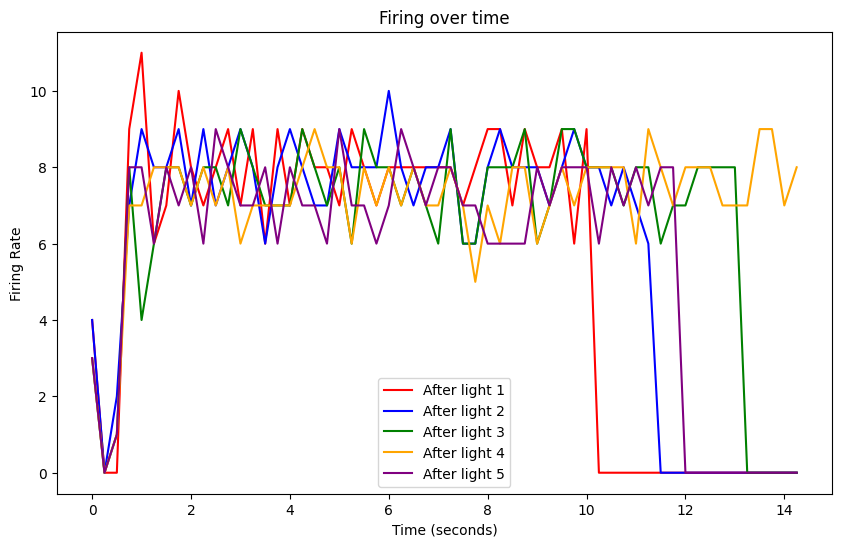

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the arrays: light0, light1, light2, light3, light4
# Ensure all arrays have the same length by padding with zeros if necessary
all_light_arrays = [light0, light1, light2, light3, light4]
max_length = max(len(light) for light in all_light_arrays)

for i, light in enumerate(all_light_arrays):
    all_light_arrays[i] = np.pad(light, (0, max_length - len(light)), mode='constant', constant_values=0)

# Sample data for x-axis (0.5 second intervals)
time_intervals = np.arange(0, max_length * 0.25, 0.25)

# Plotting the arrays with different colors
plt.figure(figsize=(10, 6))  # Set the size of the plot

colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['After light 1', 'After light 2', 'After light 3', 'After light 4', 'After light 5']

for i, light in enumerate(all_light_arrays):
    plt.plot(time_intervals, light, label=labels[i], color=colors[i])

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate')
plt.title('Firing over time')
plt.legend()

# Show the plot
plt.show()


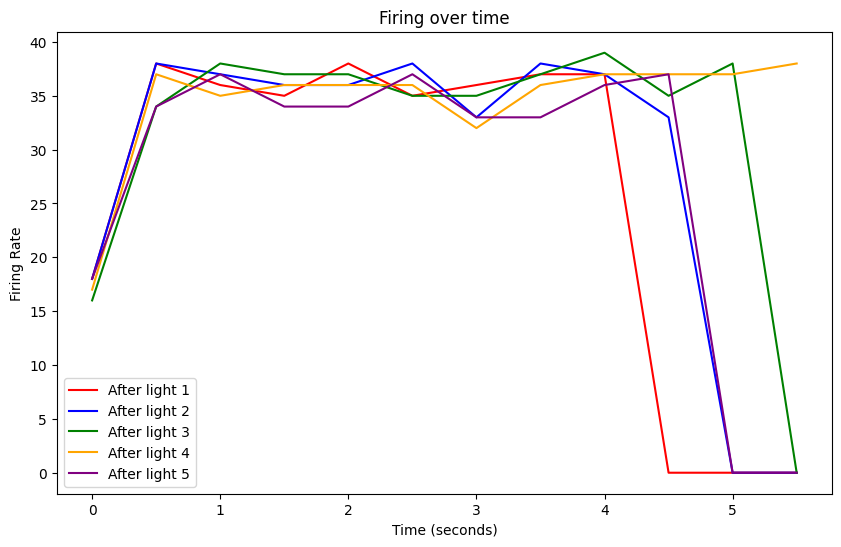

In [34]:
all_light_arrays = [light0, light1, light2, light3, light4]
max_length = max(len(light) for light in all_light_arrays)

for i, light in enumerate(all_light_arrays):
    all_light_arrays[i] = np.pad(light, (0, max_length - len(light)), mode='constant', constant_values=0)

# Sample data for x-axis (0.5 second intervals)
time_intervals = np.arange(0, max_length * 1, 1)

# Cut off data after 8 seconds
max_time = 8
num_time_points = int(max_time / 0.5)
time_intervals = time_intervals[:num_time_points]
all_light_arrays = [light[:num_time_points] for light in all_light_arrays]

# Plotting the arrays with different colors
plt.figure(figsize=(10, 6))  # Set the size of the plot

colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['After light 1', 'After light 2', 'After light 3', 'After light 4', 'After light 5']

for i, light in enumerate(all_light_arrays):
    plt.plot(time_intervals * 0.5, light, label=labels[i], color=colors[i])  # Multiply by 0.5 to convert to seconds

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate')
plt.title('Firing over time')
plt.legend()

# Show the plot
plt.show()

In [13]:
sd0_fr

NameError: name 'sd0_fr' is not defined

In [ ]:
firing_rates = calculate_mean_firing_rates(sd0)

In [32]:
def firing_plotter(sd):
    neuron_x = []
    neuron_y = []
    neuron_amp = []

    for neuron in sd.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

#     scaled_sizes = (firing_rates - np.min(firing_rates)) / (np.max(firing_rates) - np.min(firing_rates))
#     scaled_sizes = scaled_sizes * 1000 + 20  # Adjust the scaling factor as desired

    plt.figure(figsize=(8, 6))
    # Increase the 's' parameter to make the scatter points larger
    # Adjust the 'alpha' parameter to make the scatter points less opaque
    plt.scatter(neuron_x, neuron_y, s=firing_rates*100, alpha=0.3,c ='r')

    plt.show()

In [33]:
firing_plotter(sd0)